## Mounting drive

In [ ]:
# Mounting the drive
import os

from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Loading necessary libraries

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV
from sklearn.metrics import classification_report

## Loading in datasets

In [ ]:
# ===========================
# STEP 1: Load and Process SPX500 Data
# ===========================
spx_path = "/content/drive/MyDrive/Masters Thesis/Colab notebook/Data scrapers/yfinance_stock_data.csv"
spx = pd.read_csv(spx_path)
spx['Date'] = pd.to_datetime(spx['Date']).dt.date

# Compute daily return (pct_change calculates percentage change from previous row)
spx['Daily_Return'] = spx['Close'].pct_change()
# Keep only the Date and Daily_Return columns, and drop the first row (NaN from pct_change)
spx = spx[['Date', 'Daily_Return']].dropna()



# ===========================
# STEP 2: Load and Process Twitter Sentiment Data
# ===========================
twitter_path = "/content/drive/MyDrive/Masters Thesis/Colab notebook/Sentiment analysis/RoBERTa_sentiment_preds_reply.xlsx"
df = pd.read_excel(twitter_path)
df['Date'] = pd.to_datetime(df['Date']).dt.date

# Ensure Verified_Status is numeric/binary (if not, convert it)
# If the column is already binary (1/0), no extra changes are needed.
df['Verified_Status'] = df['Verified_Status'].astype(int)

# Create sentiment dummy variables from the 'Prediction' column
sentiment_dummies = pd.get_dummies(df['Prediction'])
df = pd.concat([df, sentiment_dummies], axis=1)

## Creating Train/Test split

In [ ]:
# ===========================
# STEP 3: Aggregate Twitter Data by Date
# ===========================
# We group by date and use different aggregation functions:
# - Sum counts (e.g., negative, neutral, positive counts)
# - Mean for numerical quantities (Confidence, engagement metrics)
# - For Verified_Status, taking the mean gives the fraction of verified posts.
daily_agg = df.groupby('Date').agg({
    'negative': 'sum',
    'neutral': 'sum',
    'positive': 'sum',
    'Confidence': 'mean',
    'Follower_Count': 'mean',
    'Verified_Status': 'mean',     # The mean will give the fraction of verified posts.
    'Author_Handle': 'count'         # Count of posts for the day.
}).rename(columns={'Author_Handle': 'Post_Count'})

# ===========================
# STEP 4: Merge Twitter and SPX500 Data & Create Lagged Features
# ===========================
# Merge the aggregated twitter data with the stock data on 'Date'
data = pd.merge(daily_agg, spx, on='Date', how='inner')

# Create a lagged return feature (previous day's return)
data['Prev_Return'] = data['Daily_Return'].shift(1)

# Create a binary target: 1 if today's return > 0, 0 otherwise
data['Target'] = (data['Daily_Return'] > 0).astype(int)

# Drop rows with missing values (the first row will have a missing Prev_Return)
data = data.dropna()

# ===========================
# STEP 5: Define Features and Labels
# ===========================
# Drop the Daily_Return (original return value) to prevent leakage.
# Use all other features (including Prev_Return) to predict the binary target.
features_to_drop = ['Daily_Return', 'Target', 'Date']
X = data.drop(columns=features_to_drop)
y = data['Target']

print("Data shape (after merging and dropping NAs):", data.shape)

# For time series data, we may wish to avoid random shuffling.
# We'll use a sequential split (first 80% for training, last 20% for testing).
split_index = int(len(data) * 0.8)
X_train, X_test = X.iloc[:split_index], X.iloc[split_index:]
y_train, y_test = y.iloc[:split_index], y.iloc[split_index:]

print("X_train:", X_train.shape)
print("y_train:", y_train.shape)
print("X_test:", X_test.shape)
print("y_test:", y_test.shape)

Data shape (after merging and dropping NAs): (748, 11)
X_train: (598, 8)
y_train: (598,)
X_test: (150, 8)
y_test: (150,)


# 1. Random forest with cross-validation

In [ ]:
# ===========================
# MODEL 1: Random Forest Classifier with Cross-Validation
# ===========================
model_cv = RandomForestClassifier(n_estimators=100, random_state=42)
# Perform 5-fold cross-validation on the training set
cv_scores = cross_val_score(model_cv, X_train, y_train, cv=5, scoring='accuracy')
print("Model 1: Cross-Validation")
print("Cross-Validation Accuracy Scores:", cv_scores)
print("Mean CV Accuracy: {:.4f}".format(cv_scores.mean()))

# Fit the model on the training data and evaluate on the test set
model_cv.fit(X_train, y_train)
y_pred_cv = model_cv.predict(X_test)
print("\nClassification Report (Cross-Validation Model):")
print(classification_report(y_test, y_pred_cv))

Model 1: Cross-Validation
Cross-Validation Accuracy Scores: [0.61666667 0.66666667 0.64166667 0.60504202 0.50420168]
Mean CV Accuracy: 0.6068

Classification Report (Cross-Validation Model):
              precision    recall  f1-score   support

           0       0.51      0.40      0.45        62
           1       0.63      0.73      0.68        88

    accuracy                           0.59       150
   macro avg       0.57      0.57      0.56       150
weighted avg       0.58      0.59      0.58       150



# 2. Random forest with grid search


Model 2: Grid Search
Best Parameters from Grid Search: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 2, 'n_estimators': 100}

Classification Report (Grid Search Model):
              precision    recall  f1-score   support

           0       0.54      0.24      0.33        62
           1       0.61      0.85      0.71        88

    accuracy                           0.60       150
   macro avg       0.58      0.55      0.52       150
weighted avg       0.58      0.60      0.56       150



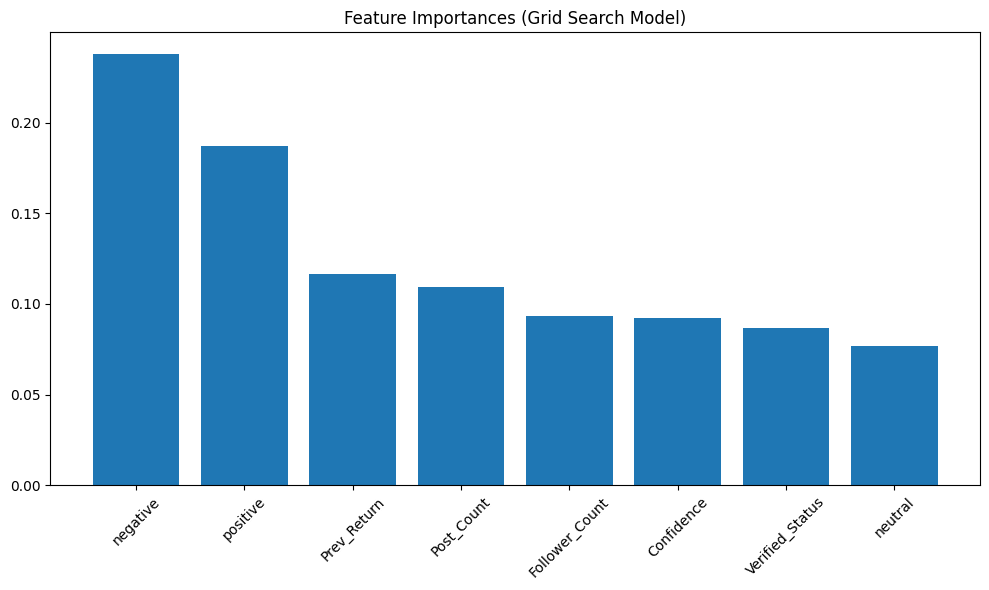

In [ ]:
# ===========================
# MODEL 2: Random Forest Classifier with Grid Search
# ===========================
# Define parameter grid for grid search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 5, 10],
    'min_samples_split': [2, 5],
    'min_samples_leaf': [1, 2]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='accuracy', n_jobs=-1)
grid_search.fit(X_train, y_train)

print("\nModel 2: Grid Search")
print("Best Parameters from Grid Search:", grid_search.best_params_)

best_model = grid_search.best_estimator_
# Evaluate the best model on the test set
y_pred_grid = best_model.predict(X_test)
print("\nClassification Report (Grid Search Model):")
print(classification_report(y_test, y_pred_grid))

# ===========================
# OPTIONAL: Plot Feature Importances from the Best Grid Search Model
# ===========================
importances = best_model.feature_importances_
feat_names = X.columns
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("Feature Importances (Grid Search Model)")
plt.bar(range(len(feat_names)), importances[indices], align="center")
plt.xticks(range(len(feat_names)), feat_names[indices], rotation=45)
plt.tight_layout()
plt.show()

#Full final RF model

In [3]:
# 0) Install required libraries
!pip install scikit-learn openpyxl --quiet

# 1) Imports
import numpy as np
import pandas as pd

from sklearn.ensemble    import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics     import (
    r2_score,
    mean_squared_error,
    accuracy_score,
    classification_report
)

# ─────────────────────────────────────────────────────────────────────────────
# 2) Configuration: paths, target, and feature list matching your columns
TRAIN_PATH = "/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_training_data_.xlsx"
VAL_PATH   = "/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_validation_data.xlsx"
TEST_PATH  = "/content/drive/MyDrive/Masters Thesis/Colab notebook/combined_test_data.xlsx"

TARGET   = "return_t+1"
FEATURES = [
    "IWSS_Equal",
    "IWSS_Ratio",
    "IWSS_Impurity",
    "IWSS_perm",
    "IWSS_SHAP",
    "Sentiment_score",
    "return_t",
    "Close",
    "High",
    "Low",
    "Open",
    "Volume",
    "VIX"
]
# ─────────────────────────────────────────────────────────────────────────────


# 3) Load raw data
def load_raw(path):
    df = pd.read_excel(path, parse_dates=["trading_day","Date"])
    df.sort_values("trading_day", inplace=True)
    df.reset_index(drop=True, inplace=True)
    return df

train_df = load_raw(TRAIN_PATH)
val_df   = load_raw(VAL_PATH)
test_df  = load_raw(TEST_PATH)


# 4) Drop rows missing any of the FEATURES or the TARGET
for ds in (train_df, val_df, test_df):
    ds.dropna(subset=FEATURES + [TARGET], inplace=True)
    ds.reset_index(drop=True, inplace=True)


# 5) Prepare X/y for regression
X_train_reg = train_df[FEATURES]
y_train_reg = train_df[TARGET]
X_val_reg   = val_df[FEATURES]
y_val_reg   = val_df[TARGET]
X_test_reg  = test_df[FEATURES]
y_test_reg  = test_df[TARGET]


# 6) Train RandomForestRegressor
rf_reg = RandomForestRegressor(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_reg.fit(X_train_reg, y_train_reg)


# 7) Evaluate regression
def eval_reg(model, X, y, label):
    preds = model.predict(X)
    r2    = r2_score(y, preds)
    mse   = mean_squared_error(y, preds)
    rmse  = np.sqrt(mse)
    print(f"[RF REG] {label} → R² = {r2:+.4f}, RMSE = {rmse:.4f}")

eval_reg(rf_reg, X_train_reg, y_train_reg, "Train")
eval_reg(rf_reg, X_val_reg,   y_val_reg,   "Val")
eval_reg(rf_reg, X_test_reg,  y_test_reg,  "Test")


# 8) Prepare X/y for classification (up/down on return_t+1)
for ds in (train_df, val_df, test_df):
    ds["up"] = (ds[TARGET] > 0).astype(int)

X_train_clf = train_df[FEATURES]
y_train_clf = train_df["up"]
X_val_clf   = val_df[FEATURES]
y_val_clf   = val_df["up"]
X_test_clf  = test_df[FEATURES]
y_test_clf  = test_df["up"]


# 9) Train RandomForestClassifier
rf_clf = RandomForestClassifier(
    n_estimators=200,
    max_depth=None,
    min_samples_split=5,
    random_state=42,
    n_jobs=-1
)
rf_clf.fit(X_train_clf, y_train_clf)


# 10) Evaluate classification
def eval_clf(model, X, y, label):
    preds = model.predict(X)
    acc   = accuracy_score(y, preds)
    print(f"[RF CLF] {label} → Accuracy = {acc:.3f}")
    print(classification_report(y, preds, digits=3))

eval_clf(rf_clf, X_train_clf, y_train_clf, "Train")
eval_clf(rf_clf, X_val_clf,   y_val_clf,   "Val")
eval_clf(rf_clf, X_test_clf,  y_test_clf,  "Test")


[RF REG] Train → R² = +0.7933, RMSE = 0.0057
[RF REG] Val → R² = -0.9938, RMSE = 0.0099
[RF REG] Test → R² = -1.0326, RMSE = 0.0121
[RF CLF] Train → Accuracy = 1.000
              precision    recall  f1-score   support

           0      1.000     1.000     1.000       244
           1      1.000     1.000     1.000       215

    accuracy                          1.000       459
   macro avg      1.000     1.000     1.000       459
weighted avg      1.000     1.000     1.000       459

[RF CLF] Val → Accuracy = 0.476
              precision    recall  f1-score   support

           0      0.432     0.966     0.597        59
           1      0.867     0.148     0.252        88

    accuracy                          0.476       147
   macro avg      0.649     0.557     0.425       147
weighted avg      0.692     0.476     0.391       147

[RF CLF] Test → Accuracy = 0.401
              precision    recall  f1-score   support

           0      0.403     0.918     0.560        61
      